# Predicting Home Loans' Repayment and Analysis of Unbanked Population

The unbanked population, consumers without adequate credit history, will go to an untrustworthy lender who could take unfair advantage of their situation because reputable banks will not provide them with loans. The subprime loans have caused enough damage to our economic system, so our task is to help identify worthy candidates 


However, there could be other ways to determine the credit worthiness of applicants. The vision of Home Credit Group is to provide fair and equal services to a non-traditional home loan applicant. 


1) Determine if the applicant will likely repay their loan by using previous credit information via the Home Credit Group's databases and the Credit Bureau

2) Find non-traditional methods to determine the credit worthiness of an applicant

In [1]:
import pandas as pd
import numpy as np
import pickle

#Allows to see up to 500 columns within notebook
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# Load datasets into dataframes

In [2]:
df_application_train = pd.read_csv('application_train.csv',header=0,error_bad_lines=False,nrows=50000)
df_previous_application = pd.read_csv('previous_application.csv',header=0,error_bad_lines=False)
df_installment_payments = pd.read_csv('installments_payments.csv',header=0,error_bad_lines=False)
df_bureau = pd.read_csv('bureau.csv',header=0,error_bad_lines=False)

#I do not use the following datasets within this notebook. However, it could be useful at a later time.
df_bureau_bal = pd.read_csv('bureau_balance.csv',header=0,error_bad_lines=False,nrows=5000)
df_pos_cash_bal = pd.read_csv('POS_CASH_balance.csv',header=0,error_bad_lines=False,nrows=5000)
df_credit_card_bal = pd.read_csv('credit_card_balance.csv',header=0,error_bad_lines=False,nrows=5000)

#dflist = [df_application_train,df_previous_application,df_installment_payments,df_bureau,df_bureau_bal,df_pos_cash_bal,df_credit_card_bal]


#Drop Data for Application IDs not included within application train dataset

df_previous_application['TARGET APPS'] = df_previous_application.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
df_installment_payments['TARGET APPS'] = df_installment_payments.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
df_bureau['TARGET APPS'] = df_bureau.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
#df_bureau_bal['TARGET APPS'] = df_bureau_bal.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
df_pos_cash_bal['TARGET APPS'] = df_pos_cash_bal.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
df_credit_card_bal['TARGET APPS'] = df_credit_card_bal.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)


df_previous_application_new = df_previous_application[df_previous_application['TARGET APPS']==True]
df_installment_payments_new = df_installment_payments[df_installment_payments['TARGET APPS']==True]
df_bureau_new = df_bureau[df_bureau['TARGET APPS']==True]
#df_bureau_bal_new = df_bureau_bal[df_bureau_bal['TARGET APPS']==True]
df_pos_cash_new = df_pos_cash_bal[df_pos_cash_bal['TARGET APPS']==True]
df_credit_card_bal_new = df_credit_card_bal[df_credit_card_bal['TARGET APPS']==True]

# Example of a dataset: Previous Application Dataset

Started with Previous Application Dataset because it had historical information about the applicant and the mortgage lender's previous decision, so I believe it is extremely important. 

In [3]:
df_previous_application_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229287 entries, 1 to 1670202
Data columns (total 38 columns):
SK_ID_PREV                     229287 non-null int64
SK_ID_CURR                     229287 non-null int64
NAME_CONTRACT_TYPE             229287 non-null object
AMT_ANNUITY                    179486 non-null float64
AMT_APPLICATION                229287 non-null float64
AMT_CREDIT                     229287 non-null float64
AMT_DOWN_PAYMENT               107788 non-null float64
AMT_GOODS_PRICE                177634 non-null float64
WEEKDAY_APPR_PROCESS_START     229287 non-null object
HOUR_APPR_PROCESS_START        229287 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    229287 non-null object
NFLAG_LAST_APPL_IN_DAY         229287 non-null int64
RATE_DOWN_PAYMENT              107788 non-null float64
RATE_INTEREST_PRIMARY          758 non-null float64
RATE_INTEREST_PRIVILEGED       758 non-null float64
NAME_CASH_LOAN_PURPOSE         229287 non-null object
NAME_CONTRACT_STATUS      

# Functions to Aggregate Data and Merging

In [4]:

# Function to calculate missing values by columns

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]>0].shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
    
# Function to create dictionary for Pivot Table's aggfunc parameter based on dtype of the column    
def aggfuncdic(df):
    dictionary = {}

    for i in df.columns:
        if df[i].dtype == 'object':
            dictionary[i] = lambda x: len(x.unique())
        else:
            dictionary[i] = [min,max,np.mean,sum]
    return dictionary

#Function to flatten multilevel pivot table for easier merging with train dataset
def flatten_multilevel_col(df):
    new_cols = [''.join(t) for t in df.columns]
    df.columns = new_cols
    return df

# Merging Supporting Datasets with Training Dataset

Previous application dataset has all of the previous application available. Currently, it has a 1:many relationship to the application dataset, so I will need to aggregate the columns before merging. Below is where I aggreagated the previous_application dataset by using index 'SK_ID_CURR'. The purpose of this is so I can provide a 1:1 relationship to the train/test dataset, while limit the columns created.

In [5]:
#Remove any columns with greater than 80% of missing values (arbitrary threshold)
#Previous Application Dataset
missing_values = missing_values_table(df_previous_application_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_previous_application_new = df_previous_application_new[nonmissingvallist]


#Bureau Dataset
missing_values = missing_values_table(df_bureau_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_bureau_new = df_bureau_new[nonmissingvallist]

#Installment Payments Dataset
missing_values = missing_values_table(df_installment_payments_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_installment_payments_new = df_installment_payments_new[nonmissingvallist]

#Bureau Balance Dataset
#missing_values = missing_values_table(df_bureau_bal_new)
#nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
#df_bureau_bal_new = df_bureau_bal_new[nonmissingvallist]

#POS Cash Dataset
missing_values = missing_values_table(df_pos_cash_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_pos_cash_new = df_pos_cash_new[nonmissingvallist]

#Credit Card Balance Dataset
missing_values = missing_values_table(df_credit_card_bal_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_credit_card_bal_new = df_credit_card_bal_new[nonmissingvallist]

Your selected dataframe has 38 columns.
There are 14 columns that have missing values.
Your selected dataframe has 18 columns.
There are 6 columns that have missing values.
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
Your selected dataframe has 24 columns.
There are 7 columns that have missing values.


In [6]:
#Pivot each dataset with aggfunc using the aggfuncdic function

df_prevapp_pivot = pd.pivot_table(df_previous_application_new,values=df_previous_application_new.columns,index='SK_ID_CURR',
                                  aggfunc=aggfuncdic(df_previous_application_new))

df_bureau_pivot = pd.pivot_table(df_bureau_new,values=df_bureau_new.columns,index='SK_ID_CURR',
                                 aggfunc=aggfuncdic(df_bureau_new))

df_installment_payments_pivot = pd.pivot_table(df_installment_payments_new,values=df_installment_payments_new.columns,index='SK_ID_CURR',
                                               aggfunc=aggfuncdic(df_installment_payments_new))

#df_bureaubal_pivot = pd.pivot_table(df_bureau_bal_new,values=df_bureau_bal_new.columns,index='SK_ID_CURR', aggfunc=aggfuncdic(df_bureau_bal_new))

df_poscash_pivot = pd.pivot_table(df_pos_cash_new,values=df_pos_cash_new.columns,index='SK_ID_CURR',
                                               aggfunc=aggfuncdic(df_pos_cash_new))

df_creditcard_pivot = pd.pivot_table(df_credit_card_bal_new,values=df_credit_card_bal_new.columns,index='SK_ID_CURR',
                                               aggfunc=aggfuncdic(df_credit_card_bal_new))

In [7]:
#Flatten Pivots for merging
flatten_multilevel_col(df_prevapp_pivot)
flatten_multilevel_col(df_bureau_pivot)
flatten_multilevel_col(df_installment_payments_pivot)
#flatten_multilevel_col(df_bureaubal_pivot)
flatten_multilevel_col(df_poscash_pivot)
flatten_multilevel_col(df_creditcard_pivot)

,AMT_BALANCEmax,AMT_BALANCEmean,AMT_BALANCEmin,AMT_BALANCEsum,AMT_CREDIT_LIMIT_ACTUALmax,AMT_CREDIT_LIMIT_ACTUALmean,AMT_CREDIT_LIMIT_ACTUALmin,AMT_CREDIT_LIMIT_ACTUALsum,AMT_DRAWINGS_ATM_CURRENTmax,AMT_DRAWINGS_ATM_CURRENTmean,AMT_DRAWINGS_ATM_CURRENTmin,AMT_DRAWINGS_ATM_CURRENTsum,AMT_DRAWINGS_CURRENTmax,AMT_DRAWINGS_CURRENTmean,AMT_DRAWINGS_CURRENTmin,AMT_DRAWINGS_CURRENTsum,AMT_DRAWINGS_OTHER_CURRENTmax,AMT_DRAWINGS_OTHER_CURRENTmean,AMT_DRAWINGS_OTHER_CURRENTmin,AMT_DRAWINGS_OTHER_CURRENTsum,AMT_DRAWINGS_POS_CURRENTmax,AMT_DRAWINGS_POS_CURRENTmean,AMT_DRAWINGS_POS_CURRENTmin,AMT_DRAWINGS_POS_CURRENTsum,AMT_INST_MIN_REGULARITYmax,AMT_INST_MIN_REGULARITYmean,AMT_INST_MIN_REGULARITYmin,AMT_INST_MIN_REGULARITYsum,AMT_PAYMENT_CURRENTmax,AMT_PAYMENT_CURRENTmean,AMT_PAYMENT_CURRENTmin,AMT_PAYMENT_CURRENTsum,AMT_PAYMENT_TOTAL_CURRENTmax,AMT_PAYMENT_TOTAL_CURRENTmean,AMT_PAYMENT_TOTAL_CURRENTmin,AMT_PAYMENT_TOTAL_CURRENTsum,AMT_RECEIVABLE_PRINCIPALmax,AMT_RECEIVABLE_PRINCIPALmean,AMT_RECEIVABLE_PRINCIPALmin,AMT_RECEIVABLE_PRINCIPALsum,AMT_RECIVABLEmax,AMT_RECIVABLEmean,AMT_RECIVABLEmin,AMT_RECIVABLEsum,AMT_TOTAL_RECEIVABLEmax,AMT_TOTAL_RECEIVABLEmean,AMT_TOTAL_RECEIVABLEmin,AMT_TOTAL_RECEIVABLEsum,CNT_DRAWINGS_ATM_CURRENTmax,CNT_DRAWINGS_ATM_CURRENTmean,CNT_DRAWINGS_ATM_CURRENTmin,CNT_DRAWINGS_ATM_CURRENTsum,CNT_DRAWINGS_CURRENTmax,CNT_DRAWINGS_CURRENTmean,CNT_DRAWINGS_CURRENTmin,CNT_DRAWINGS_CURRENTsum,CNT_DRAWINGS_OTHER_CURRENTmax,CNT_DRAWINGS_OTHER_CURRENTmean,CNT_DRAWINGS_OTHER_CURRENTmin,CNT_DRAWINGS_OTHER_CURRENTsum,CNT_DRAWINGS_POS_CURRENTmax,CNT_DRAWINGS_POS_CURRENTmean,CNT_DRAWINGS_POS_CURRENTmin,CNT_DRAWINGS_POS_CURRENTsum,CNT_INSTALMENT_MATURE_CUMmax,CNT_INSTALMENT_MATURE_CUMmean,CNT_INSTALMENT_MATURE_CUMmin,CNT_INSTALMENT_MATURE_CUMsum,MONTHS_BALANCEmax,MONTHS_BALANCEmean,MONTHS_BALANCEmin,MONTHS_BALANCEsum,NAME_CONTRACT_STATUS<lambda>,SK_DPDmax,SK_DPDmean,SK_DPDmin,SK_DPDsum,SK_DPD_DEFmax,SK_DPD_DEFmean,SK_DPD_DEFmin,SK_DPD_DEFsum,SK_ID_CURRmax,SK_ID_CURRmean,SK_ID_CURRmin,SK_ID_CURRsum,SK_ID_PREVmax,SK_ID_PREVmean,SK_ID_PREVmin,SK_ID_PREVsum,TARGET APPSmax,TARGET APPSmean,TARGET APPSmin,TARGET APPSsum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100048,27302.400,27302.4000,27302.400,27302.400,225000,225000,225000,225000,27000.0,27000.0,27000.0,27000.0,27000.000,27000.000,27000.000,27000.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,1458.270,1458.270,1458.270,1458.270,1458.270,1458.270,1458.270,1458.270,25541.730,25541.7300,25541.730,25541.730,25956.900,25956.9000,25956.900,25956.900,25956.900,25956.9000,25956.900,25956.900,1.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,17.0,17.0,-2,-2.0,-2,-2,1,0,0,0,0,0,0,0,0,100048,100048,100048,100048,1060558,1060558,1060558,1060558,True,True,True,1.0
100059,0.000,0.0000,0.000,0.000,0,0,0,0,NaN,NaN,NaN,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000,0.000,0.0000,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000,0.000,0.000,NaN,NaN,NaN,0.0,0,0.0,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,-4,-4.0,-4,-4,1,0,0,0,0,0,0,0,0,100059,100059,100059,100059,1787234,1787234,1787234,1787234,True,True,True,1.0
100135,0.000,0.0000,0.000,0.000,90000,90000,90000,90000,NaN,NaN,NaN,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000,0.000,0.0000,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000,0.000,0.000,NaN,NaN,NaN,0.0,0,0.0,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,-5,-5.0,-5,-5,1,0,0,0,0,0,0,0,0,100135,100135,100135,100135,1880847,1880847,1880847,1880847,True,True,True,1.0
100218,748180.935,748180.9350,748180.935,748180.935,720000,720000,720000,720000,0.0,0.0,0.0,0.0,21073.905,21073.905,21073.905,21073.905,0.0,0.0,0.0,0.0,21073.905,21073.905,21073.905,21073.905,36990.450,36990.4500,36990.450,36990.450,45000.000,45000.000

# Merging datasets into application_train dataset 

In [8]:
df = df_application_train.merge(df_prevapp_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_app_train','_prev_app'),how='left')

df = df.merge(df_bureau_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_curr','_bur'),how='left')

df = df.merge(df_installment_payments_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_curr2','_instpay'),how='left')

#df = df.merge(df_bureaubal_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_curr3','_burbal'),how='left')

df = df.merge(df_poscash_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_curr4','_pos'),how='left')

df = df.merge(df_creditcard_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_curr3','_credit'),how='left')

In [9]:
missing_values = missing_values_table(df)
missing_values


Your selected dataframe has 443 columns.
There are 385 columns that have missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENTmax,49603,99.2
CNT_DRAWINGS_POS_CURRENTmean,49603,99.2
AMT_DRAWINGS_OTHER_CURRENTmin,49603,99.2
AMT_DRAWINGS_POS_CURRENTmax,49603,99.2
AMT_DRAWINGS_POS_CURRENTmean,49603,99.2
AMT_DRAWINGS_POS_CURRENTmin,49603,99.2
AMT_PAYMENT_CURRENTmin,49603,99.2
CNT_DRAWINGS_POS_CURRENTmin,49603,99.2
CNT_DRAWINGS_POS_CURRENTmax,49603,99.2
AMT_DRAWINGS_OTHER_CURRENTmax,49603,99.2


# Creating Banked Column to easily identify the banked vs unbanked population

In [10]:
#Many current applicants do not have historical information. 
#Should test the differences between the 2 groups.

df['BANKED']= df.SK_ID_CURR.isin(df_bureau.SK_ID_CURR)
df['BANKED']=df.BANKED.map({True:1,False:0})

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 444 entries, SK_ID_CURR to BANKED
dtypes: float64(371), int64(42), object(31)
memory usage: 169.8+ MB
None


# Cleaning Up Missing Values/Null Values

In [12]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 444 columns.
There are 385 columns that have missing values.


,Missing Values,% of Total Values
AMT_DRAWINGS_ATM_CURRENTmean,49603,99.2
AMT_PAYMENT_CURRENTmax,49603,99.2
CNT_DRAWINGS_ATM_CURRENTmin,49603,99.2
AMT_PAYMENT_CURRENTmin,49603,99.2
AMT_DRAWINGS_ATM_CURRENTmin,49603,99.2
CNT_DRAWINGS_POS_CURRENTmax,49603,99.2
AMT_DRAWINGS_ATM_CURRENTmax,49603,99.2
CNT_DRAWINGS_POS_CURRENTmean,49603,99.2
CNT_DRAWINGS_POS_CURRENTmin,49603,99.2
AMT_PAYMENT_CURRENTmean,49603,99.2


In [13]:
#Go to null value used throughout dataframe is 365243, so I decided to use it across the df
#df.fillna(value=0,inplace=True)
#df = df.replace(365423.000000,0.0)
#df = df.drop(df[df.AMT_INCOME_TOTAL>350000].index)

#df_nan = df.loc[:,df.columns.difference(['TARGET'])].replace(0.0,np.nan)
#df= pd.concat([df_nan,df.TARGET],axis=1)

df.DAYS_BIRTH = df.DAYS_BIRTH.apply(lambda x:x/-365)

In [14]:
#Decreasing the amount of missing data column based on a 60% threshold.15

missing_values = missing_values_table(df)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<60].index.tolist()
missing_values

Your selected dataframe has 444 columns.
There are 385 columns that have missing values.


,Missing Values,% of Total Values
AMT_DRAWINGS_ATM_CURRENTmean,49603,99.2
AMT_PAYMENT_CURRENTmax,49603,99.2
CNT_DRAWINGS_ATM_CURRENTmin,49603,99.2
AMT_PAYMENT_CURRENTmin,49603,99.2
AMT_DRAWINGS_ATM_CURRENTmin,49603,99.2
CNT_DRAWINGS_POS_CURRENTmax,49603,99.2
AMT_DRAWINGS_ATM_CURRENTmax,49603,99.2
CNT_DRAWINGS_POS_CURRENTmean,49603,99.2
CNT_DRAWINGS_POS_CURRENTmin,49603,99.2
AMT_PAYMENT_CURRENTmean,49603,99.2


In [15]:
print("Number of Columns before: ", len(df.describe().columns))

Number of Columns before:  413


In [16]:
df_decr = df[nonmissingvallist]
df_decr = df_decr.replace(np.nan,0.0)
print("Number of columns after: ",len(df_decr.describe().columns))

Number of columns after:  274


# Machine Learning Section

With AUC score as my basis of my scores, I will first use a random forest to determine a baseline. After, I will try different machine learning methods like ensemble, hyperparameter tuning, etc to continue to increase my AUC score.


In [17]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#Set index to SK_ID_CURR
df_ind = df_decr.set_index('SK_ID_CURR')
df_dumb = pd.get_dummies(df_ind.select_dtypes('object'),dummy_na=True)
df_concat_dumb = pd.concat([df_ind.select_dtypes(exclude=['object']),df_dumb],axis=1)

df_concat_dumb.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 100002 to 157876
Columns: 456 entries, LANDAREA_MEDI to ORGANIZATION_TYPE_nan
dtypes: float64(233), int64(40), uint8(183)
memory usage: 113.2 MB


In [18]:
#Create X and Y datasets for training and testing
df_test = df_concat_dumb.loc[:, df_concat_dumb.columns != 'TARGET']
y = df_concat_dumb.TARGET
x_train,x_test,y_train,y_test = train_test_split(df_test,y,test_size=.2)

#Option to normalize dataset
#minmaxscaler = MinMaxScaler()
#x_normed = minmaxscaler.fit_transform(df_test)
#print(x_normed)



In [19]:
#Use for feature elimination
#clf = LassoCV()
#model = SelectFromModel(clf,threshold=.0000001)
#model.fit(df_test,y)

#passed_feature_test = df_test.columns[model.get_support()].tolist()
#len(passed_feature_test)

#passed_feature_test.append('TARGET')
#passed_feature_test.append('AMT_INCOME_TOTAL')

#df_feateliminated = df_concat_dumb[passed_feature_test]
#len(passed_feature_test)

In [20]:
scores= []
#Train Classifier: Random Forest
clf = RandomForestClassifier(n_estimators=8)

#Fit classifier to Train data set
clf.fit(x_train,y_train)

#Predict Proba

y_predict_test = clf.predict_proba(x_test)

#Auc score if using predict_
#auc_test = metrics.roc_auc_score(y_test, y_predict_test)
#score.append(auc_test)
#print(score)
#scores(y_test,y_predict_test)

0.1812


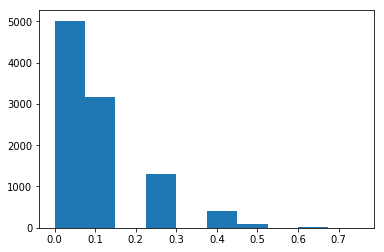

In [32]:
threshold = .24 #assign threshold for 1

print(len(y_predict_test[:,1][y_predict_test[:,1]>threshold])/len(y_predict_test))

plt.hist(y_predict_test[:,1])
plt.show()



In [33]:
new_df_target = [lambda x:1 if x >threshold else 0]
new_target = pd.DataFrame(y_predict_test[:,1]).apply(new_df_target)
print(new_target.iloc[:,0].value_counts())


0    8188
1    1812
Name: (0, <lambda>), dtype: int64


In [34]:
auc_test = metrics.roc_auc_score(y_test, new_target.values)
auc_test

0.5823143238466255

# Convert Dataframe into Pickle File for further Exploration

In [24]:
#df_feateliminated.info()

In [25]:
df_feateliminated.to_pickle('df_pickle.pkl')

NameError: name 'df_feateliminated' is not defined